In [1]:
from __future__ import division
import numpy as np
import pymc3 as pm
import scipy as sp
import seaborn as sns
from scipy import stats
from theano import tensor as tt
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
SEED = 5132290 # from random.org
np.random.seed(SEED)

## Generate input data

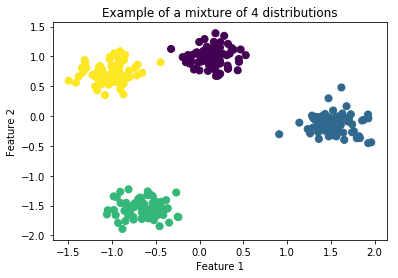

In [2]:
n_components = 4
X, truth = make_blobs(n_samples=300, centers=n_components, random_state=42)

X = StandardScaler().fit_transform(X)

plt.scatter(X[:, 0], X[:, 1], s=50, c = truth)
plt.title(f"Example of a mixture of {n_components} distributions")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2");

In [3]:
inputData= X[:,:, np.newaxis] # reshape for pymc3

In [4]:
def stick_breaking(v):
    return v * tt.concatenate([tt.ones_like(v[..., :1]),
                               tt.extra_ops.cumprod(1 - v, axis=1)[..., :-1]],
                              axis=1)

K = 20
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=(1, K))
    w = pm.Deterministic('w', stick_breaking(beta))
    w = w/w.sum()

    tau = pm.Gamma('tau', 1., 1., shape=(2, K))
    lambda_ = pm.Uniform('lambda', 0,5, shape=(2, K))
    mu = pm.Normal('mu', 0, tau=lambda_ * tau, shape=(2, K))
    obs = pm.NormalMixture('obs', w, mu, tau=lambda_ * tau, comp_shape=(2, K),
                           observed=inputData)
    trace = pm.sample(1000, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, lambda, tau, beta, alpha]
Sampling 2 chains: 100%|███████████████████████████████████████████████████████| 3000/3000 [02:18<00:00, 21.64draws/s]
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 104 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6901202616123855, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


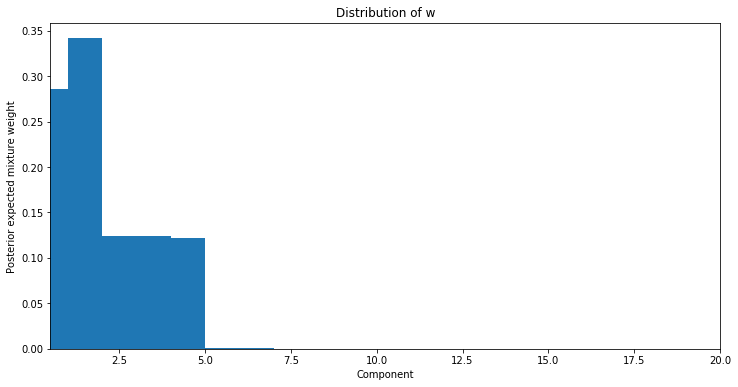

In [5]:
plt.figure(figsize=(12, 6))
plt.title(r"Distribution of w")
plt.bar(np.arange(K) + 1 - 0.5, trace['w'].mean(axis=0).ravel(), width=1., lw=0);
plt.xlim(0.5, K);
plt.xlabel('Component');
plt.ylabel('Posterior expected mixture weight');

In [6]:
w_mean = trace['w'].mean(0).ravel()
mu_mean = trace['mu'].mean(0) 
lambda_mean = trace['lambda'].mean(0)
tau_mean = trace['tau'].mean(0)
sd_mean = np.sqrt((1 / tau_mean * lambda_mean))
tau_sd = trace['mu'].std(0)
# lambda_sd = trace['lambda'].std(0)
# sd_std = np.sqrt((1 / tau_sd * lambda_sd)

Clusters found  Counter({1: 151, 0: 75, 2: 74})


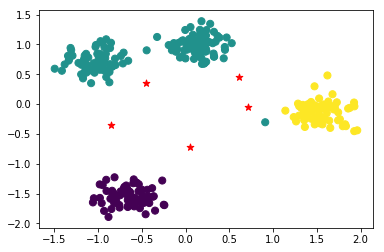

In [7]:
nClusters = 5
res = np.zeros((len(X), nClusters))
res.shape

for i in range(len(X)):
    for idx in range(nClusters):
        res[i, idx] =stats.multivariate_normal.pdf(X[i], 
                            mean=mu_mean[:, idx], cov=np.diag(sd_mean[:, idx])) * w_mean[idx]

clusters = res.argmax(axis =1)

plt.scatter(X[:, 0], X[:, 1], s=50, c = clusters)
for idx in range(nClusters):
    plt.scatter(mu_mean[:, idx][0], mu_mean[:, idx][1], s=50, c = 'red', marker ='*') # Cluster centers

print('Clusters found ', Counter(clusters))

## Evaluate performance

In [8]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(truth, clusters)

0.7013498123500752